In [58]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

In [59]:
df = pd.read_csv('../../data/international-airline-passengers.csv', index_col='time')
print(df.head())
df.plot()

         passengers
time               
1949-01         112
1949-02         118
1949-03         132
1949-04         129
1949-05         121


<AxesSubplot:xlabel='time'>

# Data cleansing

In [60]:
columns_to_keep = ['passengers']
df = df[columns_to_keep]
df['passengers'] = df['passengers'].apply(lambda x: x*1000)
df.index.names = ['Month']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 144


,passengers
Month,
1949-01,112000
1949-02,118000
1949-03,132000
1949-04,129000
1949-05,121000


In [61]:
df.describe()

,passengers
count,144.000000
mean,280298.611111
std,119966.316943
min,104000.000000
25%,180000.000000
50%,265500.000000
75%,360500.000000
max,622000.000000


In [62]:
df.plot()

<AxesSubplot:xlabel='Month'>

Null values?

In [63]:
df.isnull().sum()

passengers    0
dtype: int64

In [64]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [65]:
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [66]:
df.dropna(inplace=True)

In [67]:
df.isnull().sum()

passengers    0
dtype: int64

In [68]:
df.hist(bins=10)

array([[<AxesSubplot:title={'center':'passengers'}>]], dtype=object)

In [69]:
len(df[df['passengers'] == 0])

0

# Scaled data

In [70]:
print('Min', np.min(df))
print('Max', np.max(df))

Min passengers    104000
dtype: int64
Max passengers    622000
dtype: int64


We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [71]:
dataset = df.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

In [73]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [74]:
print(scaled[:10])

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]]


# Create the RNN

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.
Split into train and test sets

In [75]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 100
test: 44


convert an array of values into a dataset matrix

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the energy quantity at a given time (t) and Y is the qty of energy at the next time (t + 1).

In [76]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

reshape into X=t and Y=t+1

In [99]:
look_back = 12
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

100 12
0
X 0 to 12
[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703]
Y 12
0.021235526
1
X 1 to 13
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
 0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553]
Y 13
0.042471036
2
X 2 to 14
[0.05405405 0.04826255 0.03281853 0.05984557 0.08494207 0.08494207
 0.06177607 0.02895753 0.         0.02702703 0.02123553 0.04247104]
Y 14
0.07142857
3
X 3 to 15
[0.04826255 0.03281853 0.05984557 0.08494207 0.08494207 0.06177607
 0.02895753 0.         0.02702703 0.02123553 0.04247104 0.07142857]
Y 15
0.059845567
4
X 4 to 16
[0.03281853 0.05984557 0.08494207 0.08494207 0.06177607 0.02895753
 0.         0.02702703 0.02123553 0.04247104 0.07142857 0.05984557]
Y 16
0.04054053
5
X 5 to 17
[0.05984557 0.08494207 0.08494207 0.06177607 0.02895753 0.
 0.02702703 0.02123553 0.04247104 0.07142857 0.05984557 0.04054053]
Y 17
0.08687258
6
X 6 to 18
[0.08494

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].


reshape input to be [samples, time steps, features]

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(87, 12, 1)
(31, 12, 1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


create and fit the LSTM network

In [101]:
batch_size = 1
model = Sequential()
model.add(LSTM(100, batch_input_shape=(batch_size, look_back, 1), stateful=True,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
87/87 - 4s - loss: 0.0113
Epoch 2/100
87/87 - 0s - loss: 0.0059
Epoch 3/100
87/87 - 0s - loss: 0.0066
Epoch 4/100
87/87 - 0s - loss: 0.0060
Epoch 5/100
87/87 - 0s - loss: 0.0068
Epoch 6/100
87/87 - 0s - loss: 0.0052
Epoch 7/100
87/87 - 0s - loss: 0.0053
Epoch 8/100
87/87 - 0s - loss: 0.0048
Epoch 9/100
87/87 - 0s - loss: 0.0036
Epoch 10/100
87/87 - 0s - loss: 0.0026
Epoch 11/100
87/87 - 1s - loss: 0.0023
Epoch 12/100
87/87 - 0s - loss: 0.0024
Epoch 13/100
87/87 - 0s - loss: 0.0028
Epoch 14/100
87/87 - 0s - loss: 0.0017
Epoch 15/100
87/87 - 0s - loss: 0.0025
Epoch 16/100
87/87 - 0s - loss: 0.0028
Epoch 17/100
87/87 - 0s - loss: 0.0022
Epoch 18/100
87/87 - 0s - loss: 0.0022
Epoch 19/100
87/87 - 0s - loss: 0.0022
Epoch 20/100
87/87 - 0s - loss: 0.0019
Epoch 21/100
87/87 - 0s - loss: 0.0016
Epoch 22/100
87/87 - 0s - loss: 0.0018
Epoch 23/100
87/87 - 1s - loss: 0.0019
Epoch 24/100
87/87 - 1s - loss: 0.0022
Epoch 25/100
87/87 - 1s - loss: 0.0015
Epoch 26/100
87/87 - 1s - loss: 0.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

Make preditions

In [102]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train
y_train_ = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test_ = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16396.19 RMSE
Test Score: 200977.50 RMSE


Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


shift train predictions for plotting

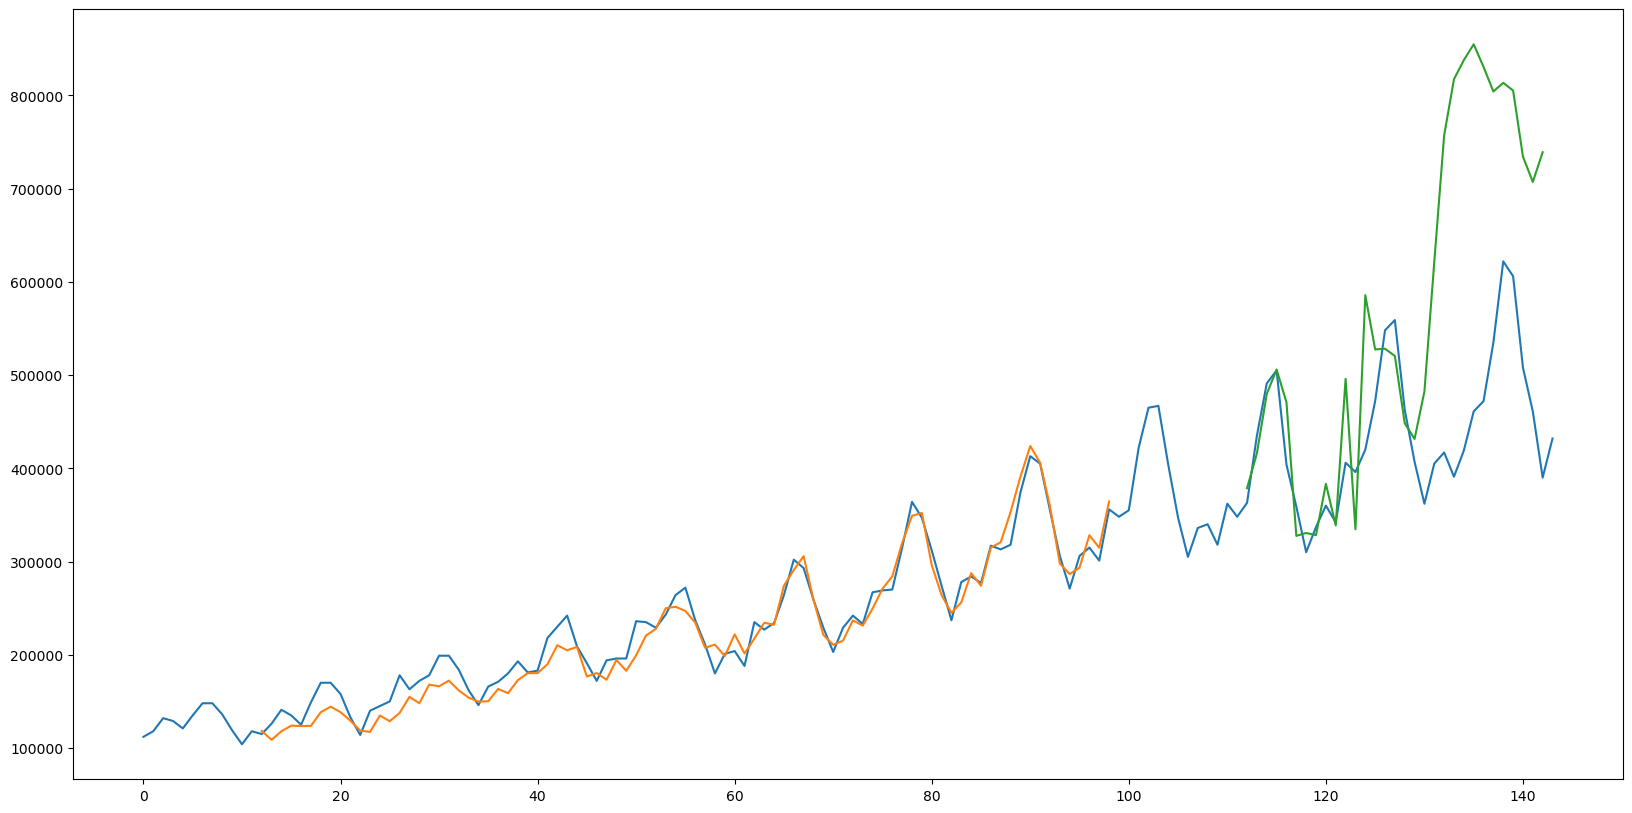

In [103]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()